# Load, Visualize MCMC Results

In [1]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import photPack2
from astropy.time import Time
import emcee
import george
from george import kernels

## Read in raw data, organize
rawch1 = np.genfromtxt('spitzer/wasp6_channel1.txt')
rawch2 = np.genfromtxt('spitzer/wasp6_channel2.txt')

# Load initial fitting parameters from spitzer/spitzer-fit-results.ipynb
spitzerinitparams = np.load('spitzer/max_lnp_params_201501301021.npy')

ch1 = {}
ch2 = {}
for rawdata, output in zip([rawch1, rawch2], [ch1, ch2]):
    for i, key, offset in zip(range(3), ['t', 'f', 'e'], [2450000.0, 0.0, 0.0]):
        output[key] = rawdata[:,i] + offset

for ch in [ch1, ch2]:
    ch['e'] = np.zeros_like(ch['f']) + np.std(ch['f'][int(0.66*len(ch['f'])):])

fluxes = np.load('photoutputs/fluxes.npy')
errors = np.load('photoutputs/errors.npy')
times = np.load('photoutputs/times.npy')
airmass = np.load('photoutputs/airmass.npy')
wavelengthbincenters = np.load('photoutputs/wavelengthbincenters.npy')
exposuredurs = np.load('photoutputs/exposuredurs.npy')
wavelengthbounds = np.load('photoutputs/wavelengthbounds.npy')

#samples = np.load('firstchain20141210.npy')
lightcurve = fluxes[:, 1, :, 0]/fluxes[:, 0, :, 0]
lightcurve_errors = lightcurve*np.sqrt((errors[:, 1, :, 0]/fluxes[:, 1, :, 0])**2 + (errors[:, 0, :, 0]/fluxes[:, 0, :, 0])**2)
Nbins = np.shape(lightcurve)[1]

In [2]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #calculates separation of centers between the planet and the star
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   
    #returns limb darkened model lightcurve
    mu_c = occultquad(z0, u1, u2, p0, npoints)   
    return F0*mu_c

from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.054
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2
period = 3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

Nbins = np.shape(lightcurve)[1]
print Nbins
Nlightcurves = Nbins + 2
# aRs, i, t0, RpRs, LD, F0, am
paramlimits = [[8.0, 14.0],  #aRs
               [85*np.pi/180, 95.0*np.pi/180],
               [np.min(times), np.max(times)],
               [np.min(times), np.max(times)]] + \
               2*3*[[0, 1.0]] +\
               Nlightcurves*[[0.0, 0.3]] + \
               Nlightcurves*[[0.1, 10]] + \
               Nbins*[[0.0, 10.0]] + Nlightcurves*[[-13, -6]]
#               Nbins*[[1.0, 1e3]]
lastp = 0

mosfire_meantimediff = np.median(np.diff(times))
ch1_meantimediff = np.median(np.diff(ch1['t']))
ch2_meantimediff = np.median(np.diff(ch2['t']))
#mosfire_exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
def fine_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t, meantimediff):
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, F0, am, eccentricity, 
              periapse, period, eps, t, meantimediff, airmassvector=airmass):
    new_t, finemodel = fine_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t, meantimediff)
    exptime = t[1] - t[0]
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    if airmassvector is None:
        return binned_model
    else:
        return binned_model*(1 + (airmassvector - 1)/am)

8


In [3]:
def genmodel(parameters, Nbins=Nbins):
    mosfiremodel = np.zeros_like(lightcurve)

    listparams = parameters.tolist()

    for eachbin in xrange(Nbins):
        mosfirelcparams = listparams[0:3] + listparams[4:6] + \
                    [parameters[10+eachbin], parameters[20+eachbin], np.exp(parameters[30+eachbin]), eccentricity, \
                     periapse, period, 1e-7, times, mosfire_meantimediff] # Fixed params
        
        mosfiremodel[:,eachbin] = binned_lc(*mosfirelcparams)
    
    spitzeram = [np.e] # placeholder argument, ignored
    ch1lcparams = listparams[0:2] + [parameters[3]] + listparams[6:8] + \
                  listparams[18:19] + listparams[28:29] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch1['t'], ch1_meantimediff]
    
    ch2lcparams = listparams[0:2] + [parameters[3]] + listparams[8:10]  + \
                  listparams[19:20] + listparams[29:30] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch2['t'], ch2_meantimediff]

    ch1model = binned_lc(*ch1lcparams, airmassvector=None)
    ch2model = binned_lc(*ch2lcparams, airmassvector=None)
    
    return mosfiremodel, ch1model, ch2model

kernellist = []
gp_objs = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
for i in range(Nlightcurves):
    # For MOSFIRE light curves:
    if i < Nbins:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)) + 
                      1e-3*kernels.ExpSquaredKernel(120)*kernels.CosineKernel(cosineperiod))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(times)
        
    # For Spitzer light curves:
    elif i == 8:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch1['t'])
    elif i == 9:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch2['t'])

def lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    mosfiremodel, ch1model, ch2model = genmodel(theta)
    w = np.exp(theta[-Nlightcurves-2*Nbins:-2*Nbins])
    amp = np.exp(theta[-2*Nbins:-Nbins])
    sig = theta[-Nbins:]
    lnlikelihoodsum = 0

    for i in range(Nlightcurves):
        # For MOSFIRE light curves:
        if i < Nbins:
            gp_objs[i].kernel.pars = [w[i], amp[i], sig[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(y_mos[:,i] - mosfiremodel[:,i])
        
        # For Spitzer light curves:
        elif i == 8:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch1['f'] - ch1model)
        elif i == 9:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch2['f'] - ch2model)
    return lnlikelihoodsum
#ma2)))

def lnprior(theta, paramlimits=paramlimits):
    parameters = theta
    # If parameter is locked, limits are set to [0,0]. If parameter is not locked,
    # check that all values for that parameter are within the set limits. If they are,
    # return 0.0, else return -np.inf
    for i, limits in enumerate(paramlimits):
        if not ((limits[0] < parameters[i]) and (parameters[i] < limits[1])):
            return -np.inf
    return 0.0

def lnprob(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2)


#labels = ['aRs', 'i', 't0_mos', 't0_spitzer'] + ['q1mos','q2mos'] + ['q1_ch1','q2_ch1'] + ['q1_ch2','q2_ch2'] +\
#         Nlightcurves*['RpRs'] + Nlightcurves*['F0'] + Nbins*['am'] + Nlightcurves*['w']

scattercoeffs = np.array([0.01, 0.005, 0.0001, 0.0001, 0.02, 0.02, 0.005, 0.01, 
                       0.01, 0.01] + Nlightcurves*[0.0001] + Nlightcurves*[0.0001] + 
                      Nbins*[0.15] + Nlightcurves*[0.15] + Nbins*[1.5] + Nbins*[0.04])
# Load recent run (from fit_results-spitzewhitekernelall?)
spitzwhitekernelall_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_201503040921.npy') 
mossqexpcos_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_mossqexpcos.npy')

# Combine these old best-fits, using white kernel hyperparams from the sqexpcos fit
initP = np.concatenate([spitzwhitekernelall_params[:-Nlightcurves], # all parameters except GP hyperparams
                        mossqexpcos_params[:Nbins], # white kernel hyperparams for mosfire
                        spitzwhitekernelall_params[-2:], # white kernel hyperparams for spitzer
                        mossqexpcos_params[Nbins:]]) # sqexpcos params for mosfire
print len(initP), len(scattercoeffs)

Nfreeparameters = len(initP)

ndim = Nfreeparameters
nwalkers = 2*Nfreeparameters if 2*Nfreeparameters % 2 == 0 else 2*Nfreeparameters + 1

pos = []
while len(pos) < nwalkers:
    trial = initP + scattercoeffs*np.random.randn(len(scattercoeffs))
    if np.isfinite(lnprior(trial)):
        pos.append(trial)

64 64


## Load chains

In [21]:
print 'Loading chain into ipynb'
#chains = np.loadtxt('/local/tmp/mosfire/longchains/mosfirespitzer/MpinkSwhite.dat')
#chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-practice.dat')
chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-parallel.dat')
#allchains = np.vstack([firstchains, chains])
allchains = chains

Loading chain into ipynb


In [22]:
burnin = int(0.5*allchains.shape[0])
lnp = allchains[burnin:, 1]
samples = allchains[burnin:, 2:]
print "Number of steps in chain: {0}".format(len(lnp))
#samples[-Nbins:] = np.exp(samples[-Nbins:])

Number of steps in chain: 155520


## Gelman Rubin

Following the directions from the original paper Gelman & Rubin (1992) and the [PyMC docs](http://pymc-devs.github.io/pymc/modelchecking.html) and the [PyMC source](https://github.com/pymc-devs/pymc/blob/master/pymc/diagnostics.py#L133)

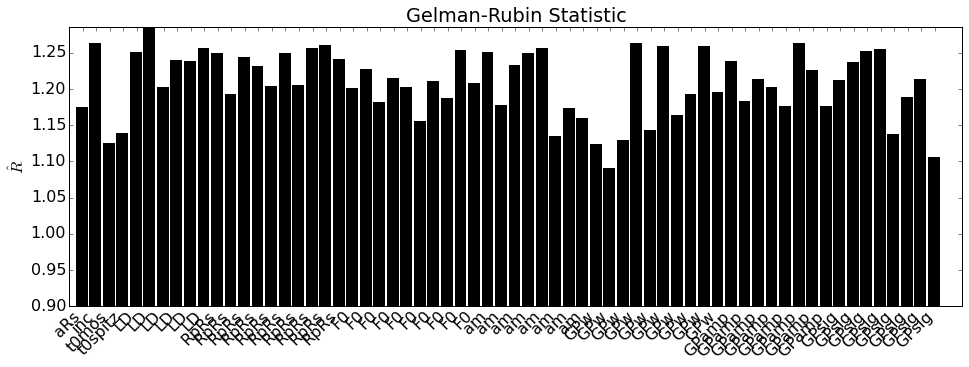

In [23]:
# chains = np.loadtxt('/local/tmp/mosfire/longchains/mosfirespitzer/chain.dat')
# burnin = int(0.0*chains.shape[0])
# lnp = chains[burnin:, 1]
# samples = chains[burnin:, 2:]
# print len(lnp)
labels = ['aRs', 'inc', 't0mos', 't0spitz'] + 2*3*['LD'] + Nlightcurves*['RpRs'] + \
         Nlightcurves*['F0'] + Nbins*['am'] + Nlightcurves*['GPw'] + Nbins*['GPamp'] + Nbins*['GPsig']
from moar import stats
Rhats = stats.gelmanrubin(allchains[:, 2:], labels=labels, plot=True)

## Log-likelihood during post-burn-in phase

In [24]:
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(8,8))
from scipy.ndimage import gaussian_filter1d
ax.set_title('$\log \,p$')
ax.plot(lnp, 'k.')#, alpha=0.08)
ax.plot(gaussian_filter1d(lnp, 0.1*len(lnp)), 'r', lw=4)
ax.plot(np.argmax(lnp), np.max(lnp), 'rs', markersize=10)

ax.set_xlabel('Step')
ax.set_ylabel('$\log \,p$')
[l.set_rotation(45) for l in ax.get_xticklabels()]
#ax.set_ylim([-2750,-2600])
plt.show()

In [159]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn
mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
fig, ax = plt.subplots(2, 2, figsize=(17,20))
for eachbin in range(len(lightcurve[0,:])):
    ax[0, 0].errorbar(times, lightcurve[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0, 0].plot(times, mosfiremodel[:,eachbin] + eachbin*0.02, 'k')

    ax[0, 1].errorbar(times, lightcurve[:,eachbin] - mosfiremodel[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    
ax[0, 0].set_xlabel('JD')
ax[0, 0].set_ylabel('Relative Flux')
    
for i, ch, model, phases in zip(range(2), [ch2, ch1], [ch2model, ch1model], [-182, -180]):
    ax[1, 0].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    ax[1, 0].plot(ch['t'] - t0_roughfit - phases*period, model + i*0.024, color='r', lw=2)
    
    ax[1, 1].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] - model + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    
#ax[0].set_title('Init Params')
plt.show()

In [25]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn
mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
fig, ax = plt.subplots(1, 3, figsize=(17,10))#, dpi=500)
spreadfactor = 0.03

gp_objs = []
kernellist = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
# for i in range(Nlightcurves):
#     # For MOSFIRE light curves:
#     if i < Nbins:

mininttime = int(np.min(times))
mtimes = times - mininttime
for eachbin in range(len(lightcurve[0,:])):
    # Gaussian process parameters
    w = np.exp(samples[max_lnp_ind,-2*Nbins-Nlightcurves+eachbin])
    amp = np.exp(samples[max_lnp_ind,-2*Nbins+eachbin])
    sig = samples[max_lnp_ind,-Nbins+eachbin]
    
    gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
    gp_obj.compute(times, w**0.5)
    
    mu, cov = gp_obj.predict(lightcurve[:,eachbin] - mosfiremodel[:,eachbin], times)
    
    # Airmass correction
    am = np.exp(samples[max_lnp_ind,30+eachbin])
    amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
    # Raw light curves
    ax[0].errorbar(mtimes, lightcurve[:,eachbin] + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(mtimes, mosfiremodel[:,eachbin] + mu + eachbin*spreadfactor, 'k')

    # Systematics corrected
    ax[1].errorbar(mtimes, (lightcurve[:,eachbin] - mu)/amcorrection + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(mtimes, mosfiremodel[:,eachbin]/amcorrection + eachbin*spreadfactor, 'k')

    #ax[1].plot(times, mu + eachbin*spreadfactor, 'k')

    # GP, transit subtracted
    ax[2].errorbar(mtimes, lightcurve[:,eachbin] - mosfiremodel[:,eachbin] - mu + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    
ax[1].set_xlabel('JD - {0:d}'.format(mininttime))
ax[0].set_ylabel('Relative Flux')

ax[0].set_title('MOSFIRE: Raw')
ax[1].set_title('Systematics corrected')
ax[2].set_title('Residuals')
fig.savefig('plots/mosfiresystematics.pdf',bbox_inches='tight')
#ax[0].set_title('Init Params')
plt.show()

## Parameters linked between all spectral bins

In [161]:
import triangle
import datetime

saveparams = False
if saveparams:
    currenttime = datetime.datetime.now().strftime('%Y%m%d%H%M')
    for directory in ['./', '/local/tmp/mosfire/longchains/mosfirespitzer/']:
        print directory+'max_lnp_params_'+currenttime+'.npy'
        np.save(directory+'max_lnp_params_'+currenttime+'.npy', max_lnp_params)

trifig, ax = plt.subplots(4, 4, figsize=(10, 10))
fig2 = triangle.corner(samples[:, 0:4], labels=['$a/R_s$','$i$','$t_0$ mos', '$t_0$ spitz'], 
                       fig=trifig, plot_datapoints=False, truths=max_lnp_params[0:4]) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

(0.11048976000000002, 0.2023164861612515, 0.052486810000000002, 0.24727193365342645, 0.16999128999999999, -0.12866844530681543)


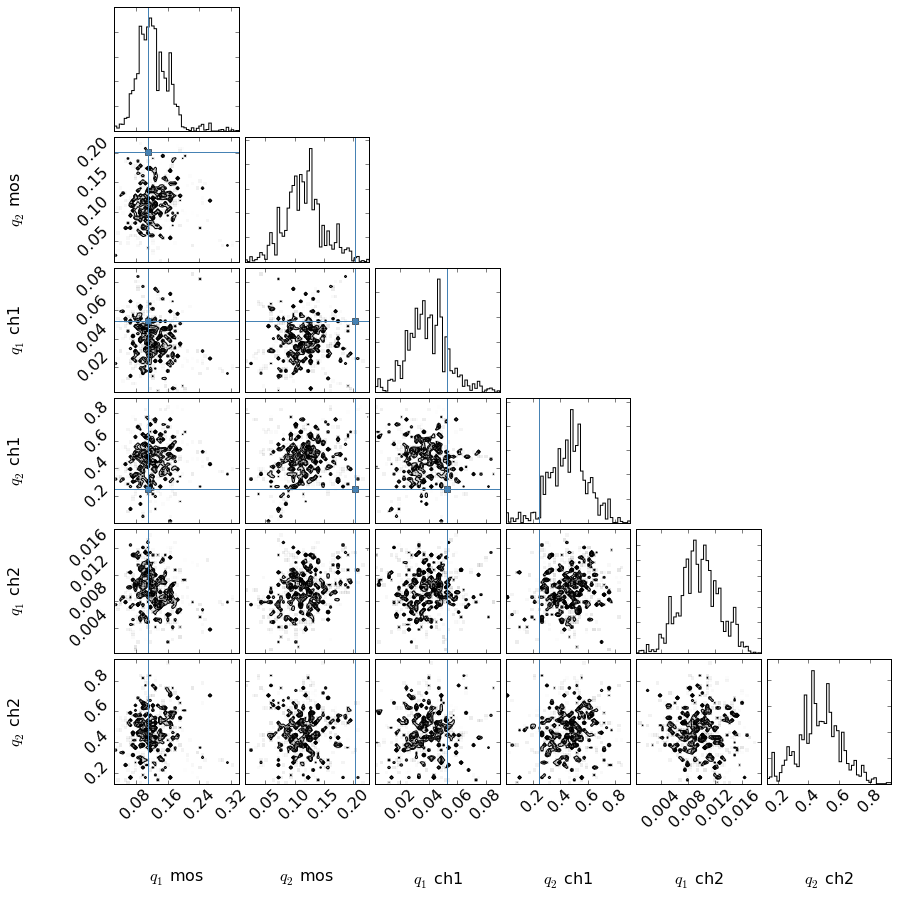

In [85]:
# Triangle plots for limb darkening parameters
trifig, ax = plt.subplots(6, 6, figsize=(12, 12))
qlabels = ['$q_1$ mos','$q_2$ mos'] + ['$q_1$ ch1','$q_2$ ch1'] + ['$q_1$ ch2','$q_2$ ch2']

from moar.claretld import quad, u2q
Teff = 5375
logg = 4.61
mosfireqs = u2q(*quad(Teff, logg, 'K'))
chi1_qs = u2q(*quad(Teff, logg, 'S1'))
chi2_qs = u2q(*quad(Teff, logg, 'S2'))
truths = mosfireqs + chi1_qs + chi2_qs
print truths

fig2 = triangle.corner(samples[::2, 4:10], labels=qlabels, 
                       fig=trifig, plot_datapoints=False, truths=truths)
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

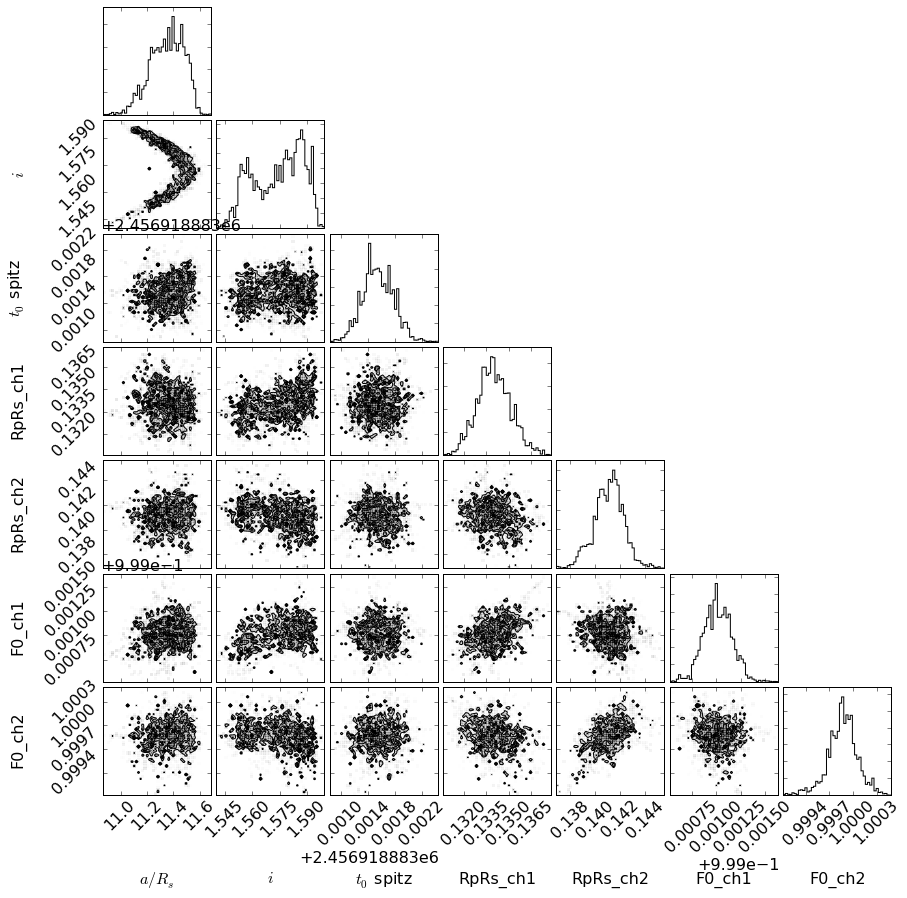

In [136]:
# Triangle plots for limb darkening parameters
spitzlabels = ['$a/R_s$','$i$', '$t_0$ spitz'] + ['RpRs_ch1','RpRs_ch2'] + ['F0_ch1','F0_ch2']
inds = [0, 1, 3, 18, 19, 28, 29]
trifig, ax = plt.subplots(len(inds), len(inds), figsize=(12, 12))
fig2 = triangle.corner(samples[::, inds], labels=spitzlabels, 
                       fig=trifig, plot_datapoints=False) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

In [21]:
# Triangle plots for limb darkening parameters
import triangle
from moar import stats
reload(stats)
firstchain = '/local/tmp/mosfire/longchains/mosfirespitzer/chain.dat'
laststate = stats.getlastchainstate(firstchain)

mosfiremodel, ch1model, ch2model = genmodel(laststate[0])#+Nlightcurves*[0])

initws = []
for i in range(Nlightcurves):
    if i < Nbins:
        initws.append(np.std(lightcurve[:,i] - mosfiremodel[:,i]))
    elif i == 8:
        initws.append(np.std(ch1['f'] - ch1model))
    elif i == 9:
        initws.append(np.std(ch2['f'] - ch2model))
initws = np.log(np.power(initws,2))
print initws

[-10.90105238 -11.08252826 -11.4609209  -11.58949884 -11.54051366
 -11.41222401 -10.39193286  -8.55109518 -11.03266959 -10.76964816]


In [137]:
wlabels = ['w'+str(i) for i in range(Nlightcurves)]
inds = range(38,48)
trifig, ax = plt.subplots(len(inds), len(inds), figsize=(12, 12))
fig2 = triangle.corner(samples[::1, inds], labels=wlabels, 
                       fig=trifig, plot_datapoints=False, truths=initws)
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

In [192]:
def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]

m, n = np.shape(samples)
print m, n
scattercoeffs = np.zeros(n)
for i in range(n):
    scattercoeffs[i] = 1.7*np.mean(medplusminus(samples[::1, i])[1:])
print scattercoeffs

297464 48
[  1.37648812e-01   1.50981402e-02   2.89000222e-04   2.54999963e-04
   6.07542540e-02   2.93964370e-01   2.32824016e-02   5.10408131e-01
   1.56487037e-02   3.38998483e-01   4.50197180e-03   3.43473406e-03
   3.51389542e-03   3.36813599e-03   3.11130188e-03   3.66003708e-03
   4.88451365e-03   1.45813033e-02   1.43517228e-03   1.60823971e-03
   2.36459893e-03   1.39080991e-03   1.53287099e-03   1.37423920e-03
   1.60119571e-03   1.01271526e-03   1.70498892e-03   7.34114233e-03
   2.30457684e-04   2.85932865e-04   1.22153018e+00   1.79628539e-01
   8.21407935e-01   1.41027910e+00   8.29207938e-01   2.59324229e+00
   2.28449395e+00   2.58111379e+00   1.52296905e-01   1.47304729e-01
   1.44394044e-01   1.56918049e-01   1.74285908e-01   1.57245560e-01
   1.48954900e-01   1.62271178e-01   7.91935475e-02   7.86389229e-02]


# Results

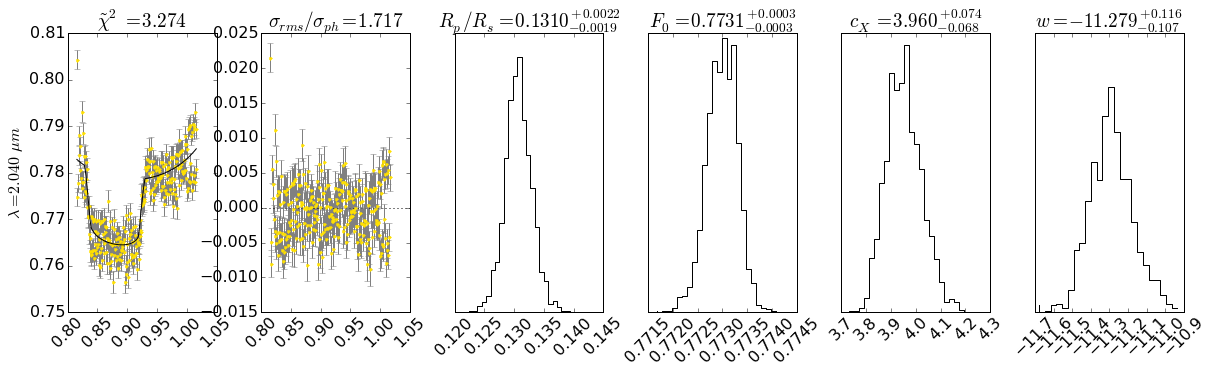

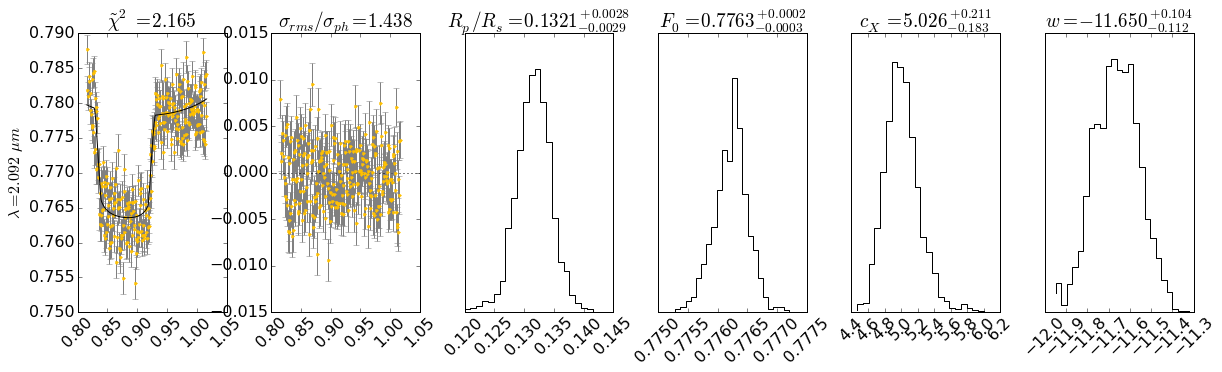

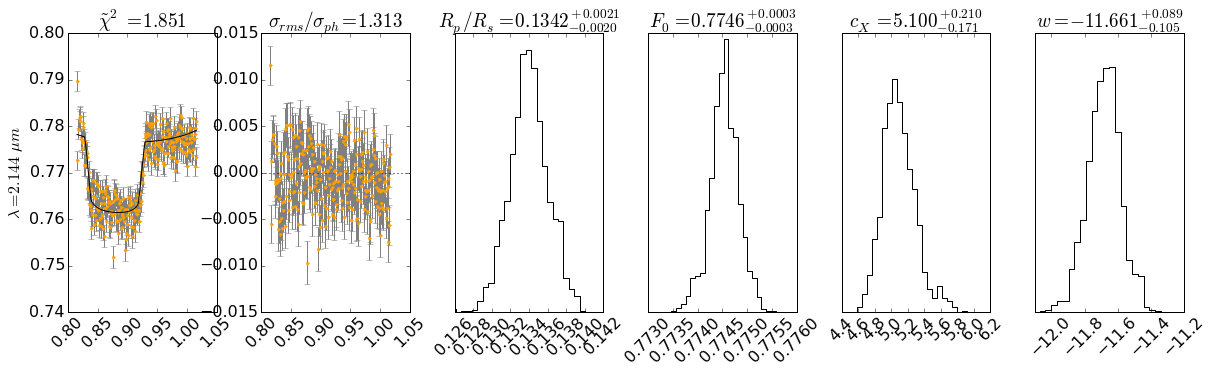

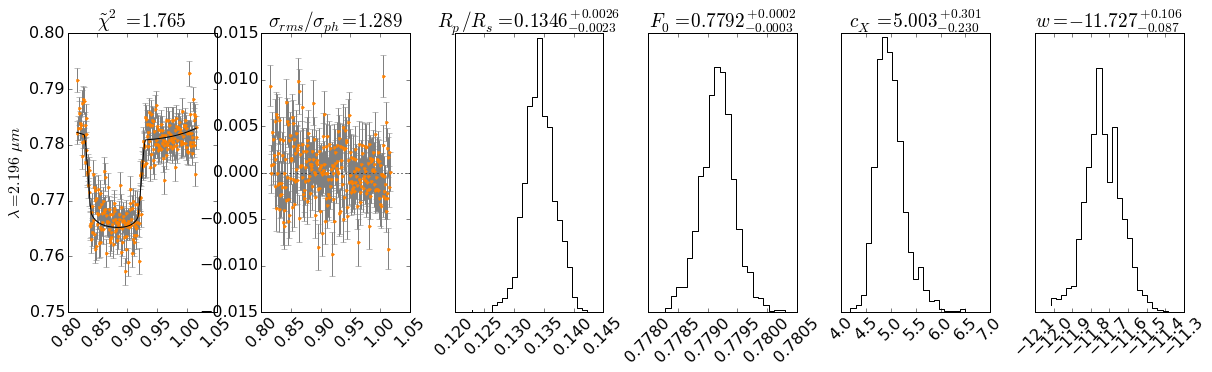

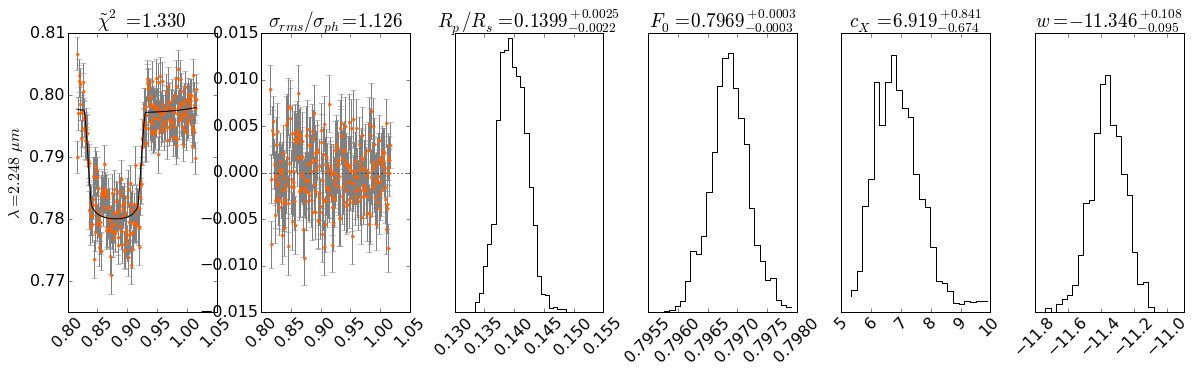

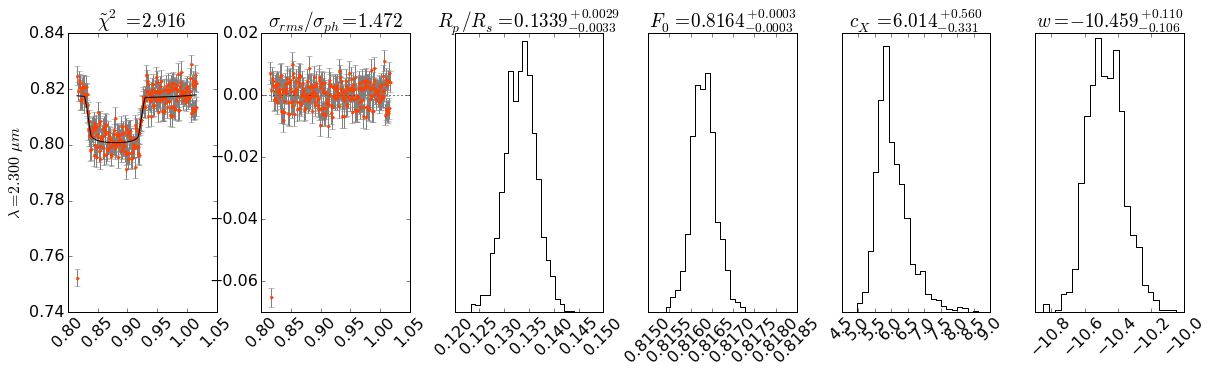

In [26]:
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.size'] = 16

def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]

def chi2(v1, v2, err, Nfreeparams):
    return np.sum( ((v1-v2)/err)**2 )/(len(v1) - Nfreeparams)

Nphotonnoise = np.zeros(Nbins)
mintimeint = int(np.min(times))
for eachbin, j in enumerate(range(2*Nbins)[::2]):
    fig = plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1, 6, wspace=0.3)
    #left_lower = plt.subplot(gs[1, 0])
    left_upper = plt.subplot(gs[0, 0])
    middle_left = plt.subplot(gs[0, 1])
    middle_right = plt.subplot(gs[0, 2])
    right = plt.subplot(gs[0, 3])
    moreright = plt.subplot(gs[0, 4])
    moremoreright = plt.subplot(gs[0, 5])
    model = mosfiremodel
    # Plot lightcurve
    left_upper.errorbar(times - mintimeint, lightcurve[:,eachbin], \
                yerr=lightcurve_errors[:,eachbin], fmt='.', \
                color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    left_upper.plot(times - mintimeint, model[:,eachbin], 'k')
    left_upper.set_ylabel(r'$\lambda = %.3f\,\mu m$' % wavelengthbincenters[eachbin])
    left_upper.set_title(r'$\tilde{\chi}^2 = %.3f$' % chi2(lightcurve[:,eachbin], \
                         model[:,eachbin], lightcurve_errors[:,eachbin], 8))
    [l.set_rotation(45) for l in left_upper.get_xticklabels()]
    
    # Plot residuals
    middle_left.axhline(0, ls=':', color='k')
    middle_left.errorbar(times - mintimeint, lightcurve[:,eachbin] - model[:,eachbin], \
                yerr=lightcurve_errors[:,eachbin], fmt='.', \
                color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    Nphotonnoise[eachbin] = np.std(lightcurve[:,eachbin] - model[:,eachbin])/np.mean(lightcurve_errors[:,eachbin])
    middle_left.set_title(r'$\sigma_{rms}/\sigma_{ph} = %.3f$' % \
                          Nphotonnoise[eachbin])
    [l.set_rotation(45) for l in middle_left.get_xticklabels()]
    
    # Plot RpRs histogram
    Nhistbins = 25
    n, edges = np.histogram(samples[:,10+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    middle_right.plot(x, n, color='k', ls='steps')
    middle_right.set_yticks([])
    #middle_right.set_xlim([0.128, 0.148])
    middle_right.set_title(r'$R_p/R_s = %.4f^{+%.4f}_{-%.4f}$' % medplusminus(samples[:,10+eachbin]))
    [l.set_rotation(45) for l in middle_right.get_xticklabels()]

    # Plot F0 histogram
    n, edges = np.histogram(samples[:,20+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    right.plot(x, n, color='k', ls='steps')
    right.set_yticks([])
    right.set_title(r'$F_0 = %.4f^{+%.4f}_{-%.4f}$' % medplusminus(samples[:,20+eachbin]))
    [l.set_rotation(45) for l in right.get_xticklabels()]

    # Plot airmass histogram
    n, edges = np.histogram(samples[:,30+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    moreright.plot(x, n, color='k', ls='steps')
    moreright.set_yticks([])
    moreright.set_title(r'$c_X = %.3f^{+%.3f}_{-%.3f}$' % medplusminus(samples[:,30+eachbin]))
    [l.set_rotation(45) for l in moreright.get_xticklabels()]

    
    n, edges = np.histogram(samples[:,38+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    moremoreright.plot(x, n, color='k', ls='steps')
    moremoreright.set_yticks([])
    moremoreright.set_title(r'$w = %.3f^{+%.3f}_{-%.3f}$' % medplusminus(samples[:,38+eachbin]))
    [l.set_rotation(45) for l in moremoreright.get_xticklabels()]    
    
    
    #fig.savefig('plots/%02d.pdf' % eachbin, bbox_inches='tight')
    #fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/%02d.eps' % eachbin, bbox_inches='tight')
plt.show()

In [28]:
with open('MOSFIREresults.txt', 'w') as f:
    for eachbin in range(Nbins):
        s = '{0:.4f} {1:.4f} {2:.4f} {3:.4f} {4:.4f}'.format(
                wavelengthbounds[eachbin][0],wavelengthbounds[eachbin][1], *medplusminus(samples[:,10+eachbin]))
        print s
        f.write(s+'\n')


1.9620 2.0141 0.1351 0.0023 0.0024
2.0141 2.0662 0.1337 0.0018 0.0018
2.0662 2.1182 0.1357 0.0018 0.0019
2.1182 2.1703 0.1361 0.0018 0.0019
2.1703 2.2224 0.1370 0.0018 0.0018
2.2224 2.2745 0.1431 0.0019 0.0019
2.2745 2.3265 0.1362 0.0025 0.0024
2.3265 2.3786 0.1394 0.0071 0.0071


In [501]:
# Make triangle plots for RpRs/F0/c_x:
matplotlib.rcParams['font.size'] = 14
reload(triangle)
import triangle

timesinds = [2]
shortenedsamples = samples.copy()
shortenedsamples[:,timesinds] -= np.median(shortenedsamples[:,timesinds])

for eachbin in range(Nbins):
    showparams = [0, 1, 2, 4, 5, 10+eachbin, 20+eachbin, 30+eachbin]
    trifig, ax = plt.subplots(len(showparams), len(showparams), figsize=(10, 10))
    fig2 = triangle.corner(shortenedsamples[:, showparams], labels=['$a/R_s$',
                           '$i$','$t_0$', '$q_1$', '$q_2$', '$R_p/R_s$', '$F_0$', '$c_X$'], 
                           fig=trifig)#, truths=max_lnp_params[0:4])

    trifig.savefig('mosfiretriangles/{0:02d}.png'.format(eachbin), bbox_inches='tight')
    plt.clf()

In [30]:
matplotlib.rcParams['font.size'] = 18
sumimg = pyfits.getdata('/local/tmp/mosfire/2014sep18_analysis/m140918_0496sum_nobadpxl.fits')
sumimg = np.sum(sumimg,axis=0)
wavelengthsoln = np.load('wavelengthsoln.npy')
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(wavelengthbincenters, Nphotonnoise, 'ko')
ax.plot(wavelengthsoln, sumimg/np.max(sumimg), color='gray')
ax.set_ylabel('$\sigma_{rms}/\sigma_{photon}$', fontsize=25)
ax.set_xlabel('Wavelength [$\mu m$]', fontsize=20)
#ax.xaxis.labelpad = 100
#ax.set_title('The Photon Noise Floor')
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/photonnoise.eps', bbox_inches='tight')
plt.show()

# Candidate Spectrum

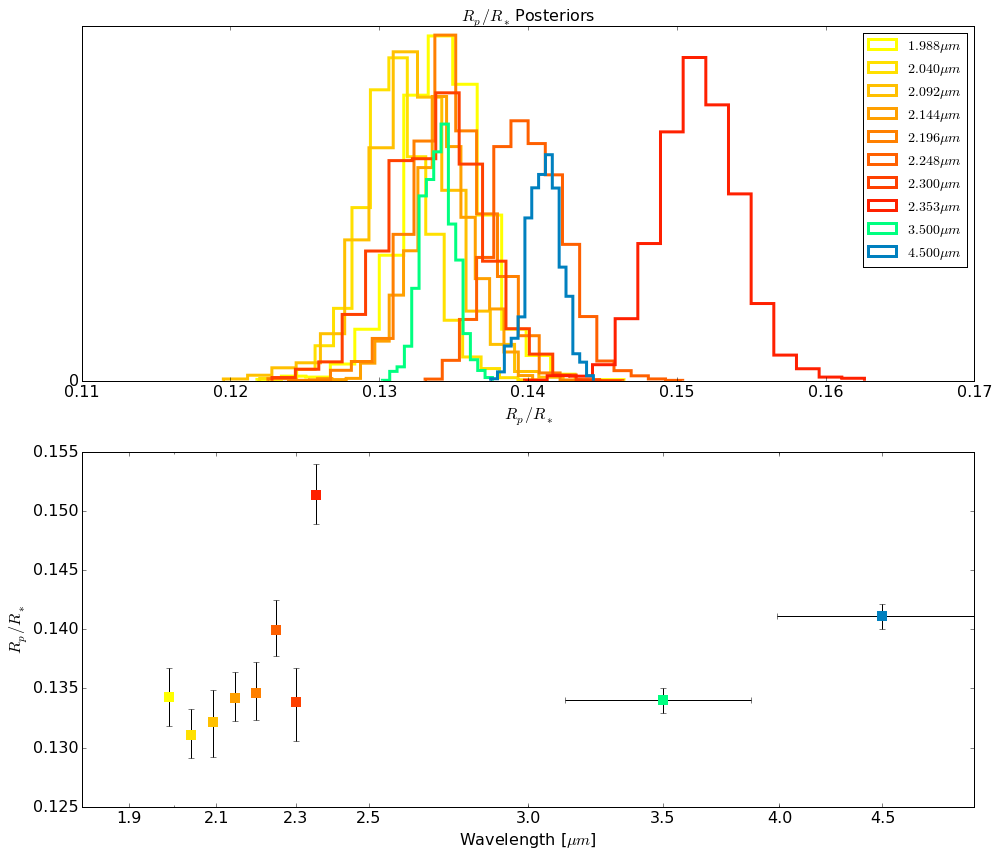

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(16,14))
histbins = 15
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')

def depthhist(ax, eachbin, cmap=plt.cm.autumn):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    RpRs = samples[:,10+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters[eachbin], bestRpRs, yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters))), \
                  ecolor='k', markeredgecolor='none', ms=10)

binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = [3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters_spitz[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), 
                  ecolor='k', markeredgecolor='none', ms=10)
    
for i in range(Nbins):
    depthhist(ax, i)
    
for i in range(2):
    depthhistspitz(ax, i)
    
ax[0].legend(fontsize=14)
ax[0].set_xlabel(r'$R_p/R_*$', fontsize=16)
ax[0].set_title(r'$R_p/R_*$ Posteriors',fontsize=16)
ax[0].set_yticks([0])

ax[1].set_xscale('log')

ax[1].set_xlabel('Wavelength [$\mu m$]', fontsize=16)
ax[1].set_ylabel(r'$R_p/R_*$', fontsize=16)

ax[1].set_xlim([1.8, 5])
xticks = [1.9, 2.1, 2.3, 2.5, 3.0, 3.5, 4.0, 4.5]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(map("{0}".format, xticks))

plt.show()

## Comparison with [Jordan et al. (2013)](http://adsabs.harvard.edu/abs/2013ApJ...778..184J) and [Nikolov et al. (2014)](http://arxiv.org/abs/1411.4567)

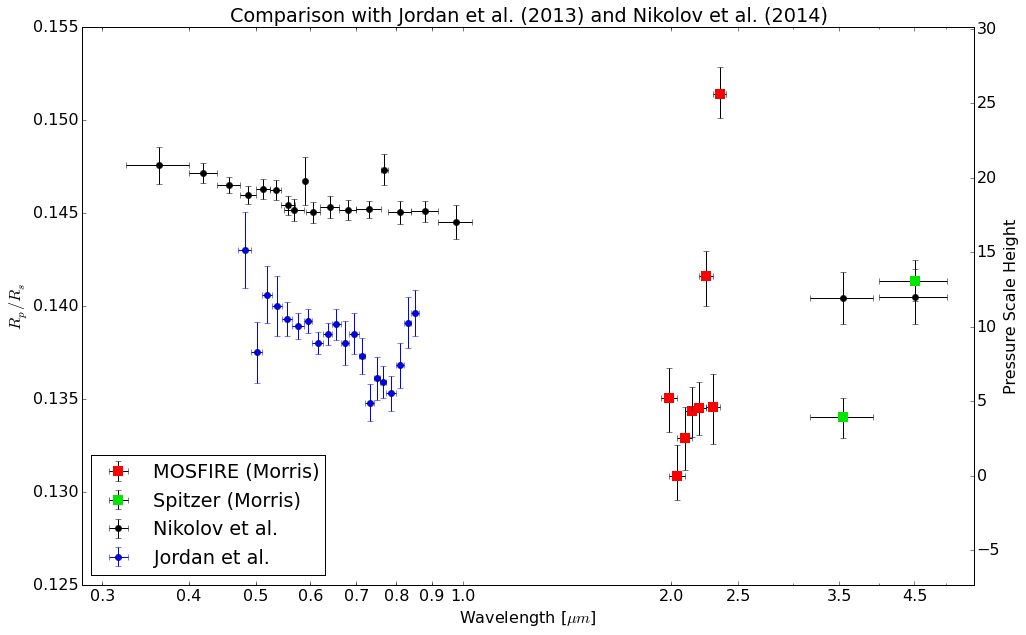

In [126]:
# MOSFIRE binwidth 
#mosfirebinwidth = 0.5*(wavelengthbincenters[1] - wavelengthbincenters[0])

# Read in Nikolov data
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')
wave_nik = np.mean([nikolovdata[:,0],nikolovdata[:,1]],axis=0)*1e-4
binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4
RpRs_nik = nikolovdata[:,2]
RpRsUnc_nik = nikolovdata[:,3]

# Read in Jordan data
jordandata = np.loadtxt('../leftnod/jordan.dat')
wave_jordan = np.mean([jordandata[:,0],jordandata[:,1]],axis=0)*1e-4
binwidth_jordan = 0.5*(jordandata[:,1]-jordandata[:,0])*1e-4
RpRs_jordan = jordandata[:,2]
RpRsUnc_jordan = np.mean([jordandata[:,3],np.abs(jordandata[:,4])],axis=0)

def depthhist(ax, eachbin):
    RpRs = samples[:,10+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)
    binwidth = wavelengthbincenters[1]-wavelengthbincenters[0]
    if eachbin == 0:
        kwargs = {'label' : 'MOSFIRE (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters[eachbin], bestRpRs, xerr=[[binwidth], [binwidth]],
                 yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color='r', ecolor='k', markeredgecolor='none', ms=10, **kwargs)
    #color=cmap(1 - i/float(len(wavelengthbincenters))), \
    return bestRpRs

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = wave_nik[-2:]#[3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    if eachbin == 0:
        kwargs = {'label' : 'Spitzer (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color='#00E600', ecolor='k', markeredgecolor='none', ms=10, **kwargs)
    return bestRpRs
    #color=cmap(1 - i/float(len(wavelengthbincenters_spitz))),

matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(16,10))

# Plot MOSFIRE
radii = []
waves = np.concatenate((wavelengthbincenters, wave_nik[-2:]))
for i in range(Nbins):
    radii.append(depthhist(ax, i))

# Plot Spitzer
for i in range(2):
    radii.append(depthhistspitz(ax, i))

# Plot Nikolov, Jordan
ax.errorbar(wave_nik, RpRs_nik, yerr=RpRsUnc_nik, xerr=binwidth_nik, fmt='o', color='k', label='Nikolov et al.')
ax.errorbar(wave_jordan, RpRs_jordan, yerr=RpRsUnc_jordan, xerr=binwidth_jordan, fmt='o', color='b', label='Jordan et al.')

## Calculate Rp/Rs -> pressure scale heights
from astropy.constants import G, k_B, M_jup, m_p, R_sun
from astropy import units as u

def scaleheights(RpRs):
    '''
    Compute scale heights at deepest radius, then return Nscaleheights for
    each radius.
    '''
    minRpRs = np.min(RpRs)
    Rs = 0.870*R_sun                # Gillon 2009
    Mp = 0.503*M_jup                # Gillon 2009
    minRp = minRpRs*Rs
    g = G*Mp/(minRp**2)
    mu = 2*m_p                      # Assuming H2 dominated atmos
    T = 1194                        # Gillon 2009
    minH = ( k_B*T/(mu*g) ).value

    #allRp = np.array([(RpRs_i*Rs).value for RpRs_i in RpRs])
    #Hs = [(Rp_i-minRp.value)/minH for Rp_i in allRp]
    Hs = lambda allRpRs: [((RpRs_i*Rs).value-minRp.value)/minH for RpRs_i in allRpRs]
    return Hs


initxlim = ax.get_xlim()
initylim = ax.get_ylim()

Hs = scaleheights(radii)
ax2 = ax.twinx()
ax2.plot(waves, Hs(radii), ',', alpha=0)
#ax2.set_xlim(initxlim)
ax2.set_ylim(Hs(initylim))
ax2.set_ylabel('Pressure Scale Height')

for axis in [ax, ax2]:
    axis.set_xlim([0.28, 5.5])
    axis.set_xscale("log")
    xticklist = np.arange(0.3, 1.1, 0.1).tolist() + [2.0, 2.5, 3.5, 4.5]
    axis.set_xticks(xticklist)
    axis.set_xticklabels(map(lambda x: '%.1f' % x, xticklist))
ax.set_title('Comparison with Jordan et al. (2013) and Nikolov et al. (2014)')

ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
ax.legend(loc='lower left', numpoints=1)
fig.savefig('plots/comparison.png', bbox_inches='tight')
plt.show()

In [204]:
paddingbounds = [110, 2130]
spectralbinbounds = np.linspace(paddingbounds[0], paddingbounds[1], Nbins+1, dtype=int)
print spectralbinbounds

firstlines = \
'''
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
physical
'''

# Box format:
# centerx centery widthx widthy rot
with open('binregions.reg','w') as reg:
    for i in range(len(spectralbinbounds)-1):
        centerx =  0.5*(spectralbinbounds[i] + spectralbinbounds[i+1])
        centery = 2024/2
        widthx = spectralbinbounds[i+1] - spectralbinbounds[i]
        widthy = 2024
        angle = 0
        linewidth = 3
        wavelength = wavelengthbincenters[i]
        reg.write("box({0:f},{1:f},{2:f},{3:f},{4:f}) # width={5} text={{{6:.3f}}} \n".format(
                  centerx, centery, widthx, widthy, angle, linewidth, wavelength))

[ 110  312  514  716  918 1120 1322 1524 1726 1928 2130]


## Compare MOSFIRE+Spitzer fits with TAP Spitzer fits

[[ 0.13125788  0.0026918   0.00256984]
 [ 0.14156172  0.00189539  0.00204403]]


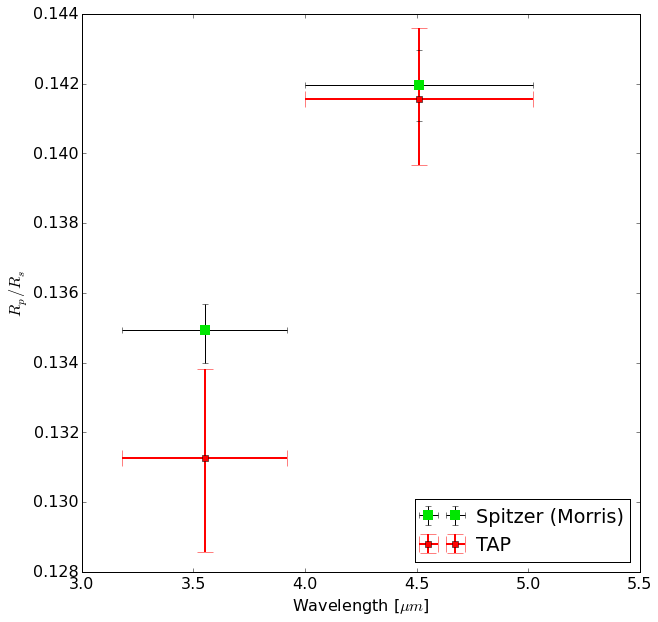

In [78]:
tapresults = np.loadtxt('TAP/TAPmcmc_20150202_1113/RpRsTAP.txt')

print tapresults
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(2):
    depthhistspitz(ax, i)
    
ax.errorbar(wave_nik[-2:], tapresults[:,0], xerr=[binwidth_nik[-2:], binwidth_nik[-2:]],
            yerr=[tapresults[:,1], tapresults[:,2]], fmt='s', color='r', elinewidth=2, capsize=8, label='TAP')
ax.legend(loc='lower right')
ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
plt.show()

## Light curves and residuals

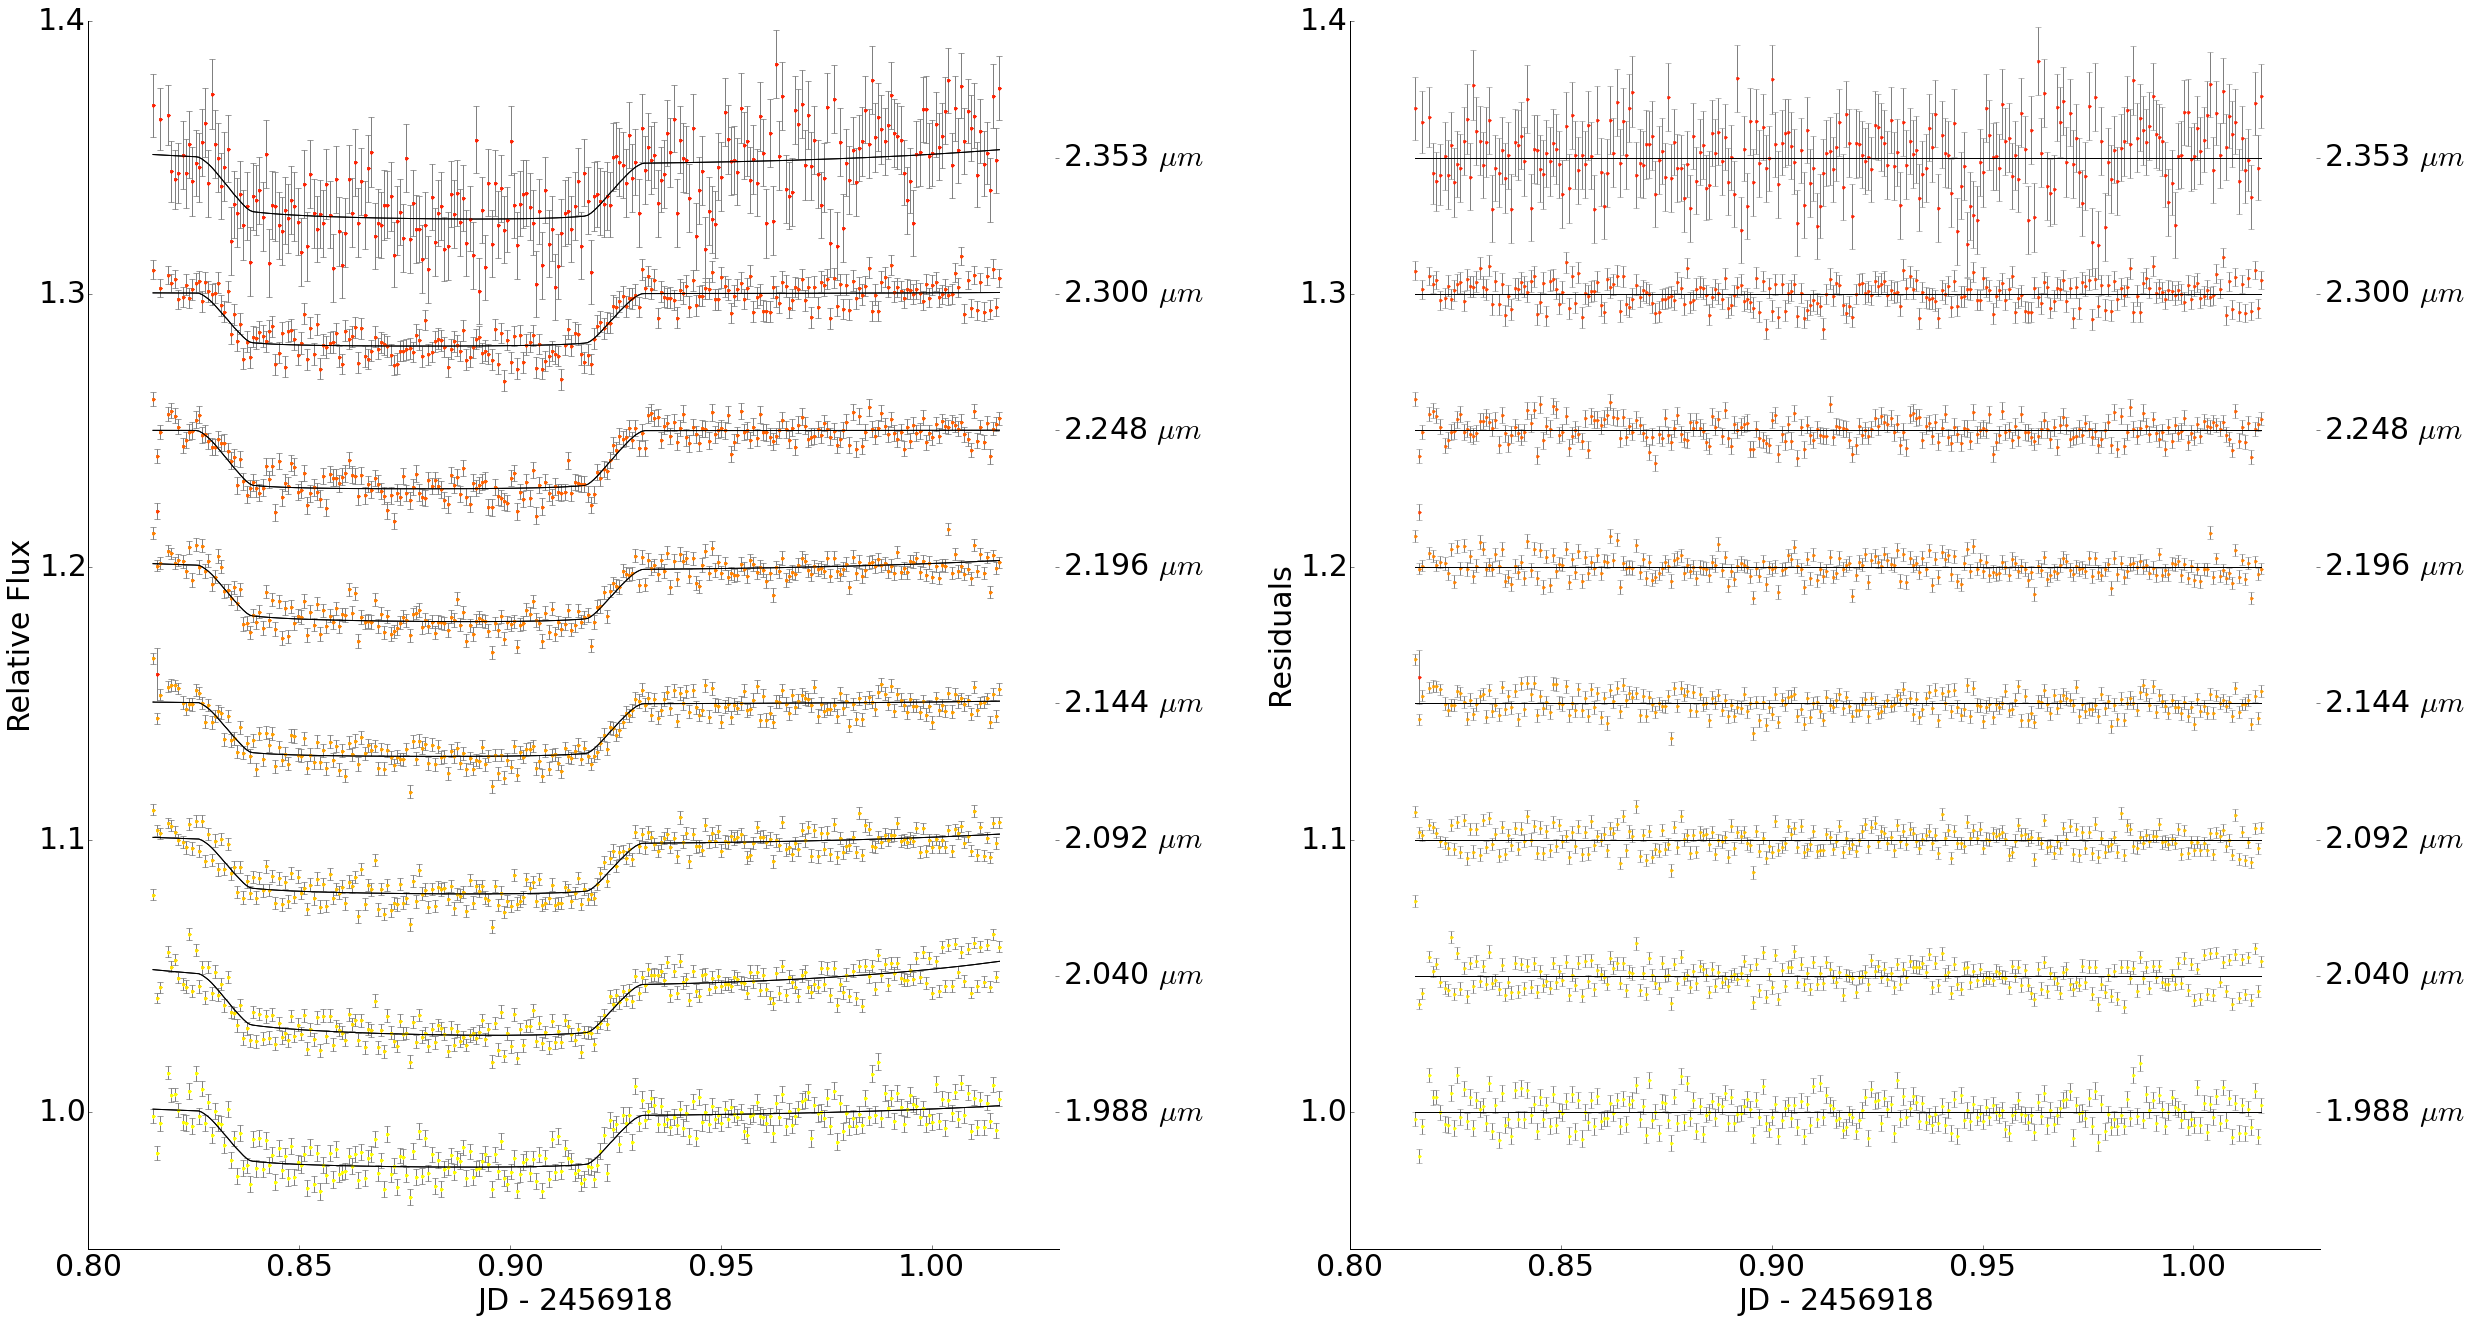

In [528]:
matplotlib.rcParams['font.size'] = 30
Nbins = np.shape(lightcurve)[1]

mosfiremodel,_,_ = genmodel(max_lnp_params)
model = mosfiremodel
mintimeint = int(np.min(times))
cmap = plt.cm.autumn
spread = 0.05
t0_roughfit = 2456918.8793039066
t14duration_expected = 0.1086 # days

fig, ax = plt.subplots(1, 2, figsize=(40,22))
#ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

ax1 = fig.add_subplot(121, frameon=False)#sharey=ax[1],
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax1.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax1.set_xticks([])

ax2 = fig.add_subplot(111, frameon=False)#sharey=ax[1],
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax2.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax2.set_xticks([])


for eachbin in range(len(lightcurve[0,:])):
    oot = (times < t0_roughfit - t14duration_expected/2.0) + \
          (times > t0_roughfit + t14duration_expected/2.0)
    bestF0 = np.mean(lightcurve[:,eachbin][oot])
    lc = lightcurve[:,eachbin]/bestF0 + eachbin*spread
    modellc = model[:,eachbin]/bestF0 + eachbin*spread
    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[1].errorbar(times - mintimeint, lc - modellc  + eachbin*spread + 1, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(times - mintimeint, np.zeros_like(modellc) + eachbin*spread + 1, \
                color='k')
    
ax[0].set_ylabel('Relative Flux')    
#ax[0].set_ylim([0.95, 1.50])
ax2.set_ylim([0.95, 1.40])
ax1.set_ylim([0.95, 1.40])

ax[1].set_ylabel('Residuals')    
#ax.grid()
for i in [0,1]:
    ax[i].set_xlabel('JD - %d' % mintimeint)
    ax[i].set_xlim([0.8, 1.03])
    ax[i].set_ylim([0.95, 1.40])
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[0].set_title('Max $\log p$ Light Curves')
fig.subplots_adjust(wspace=0.3)
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/max_lnp_lightcurves_poster.eps', bbox_inches='tight')
plt.show()

## Light curves and residuals and Photon noise

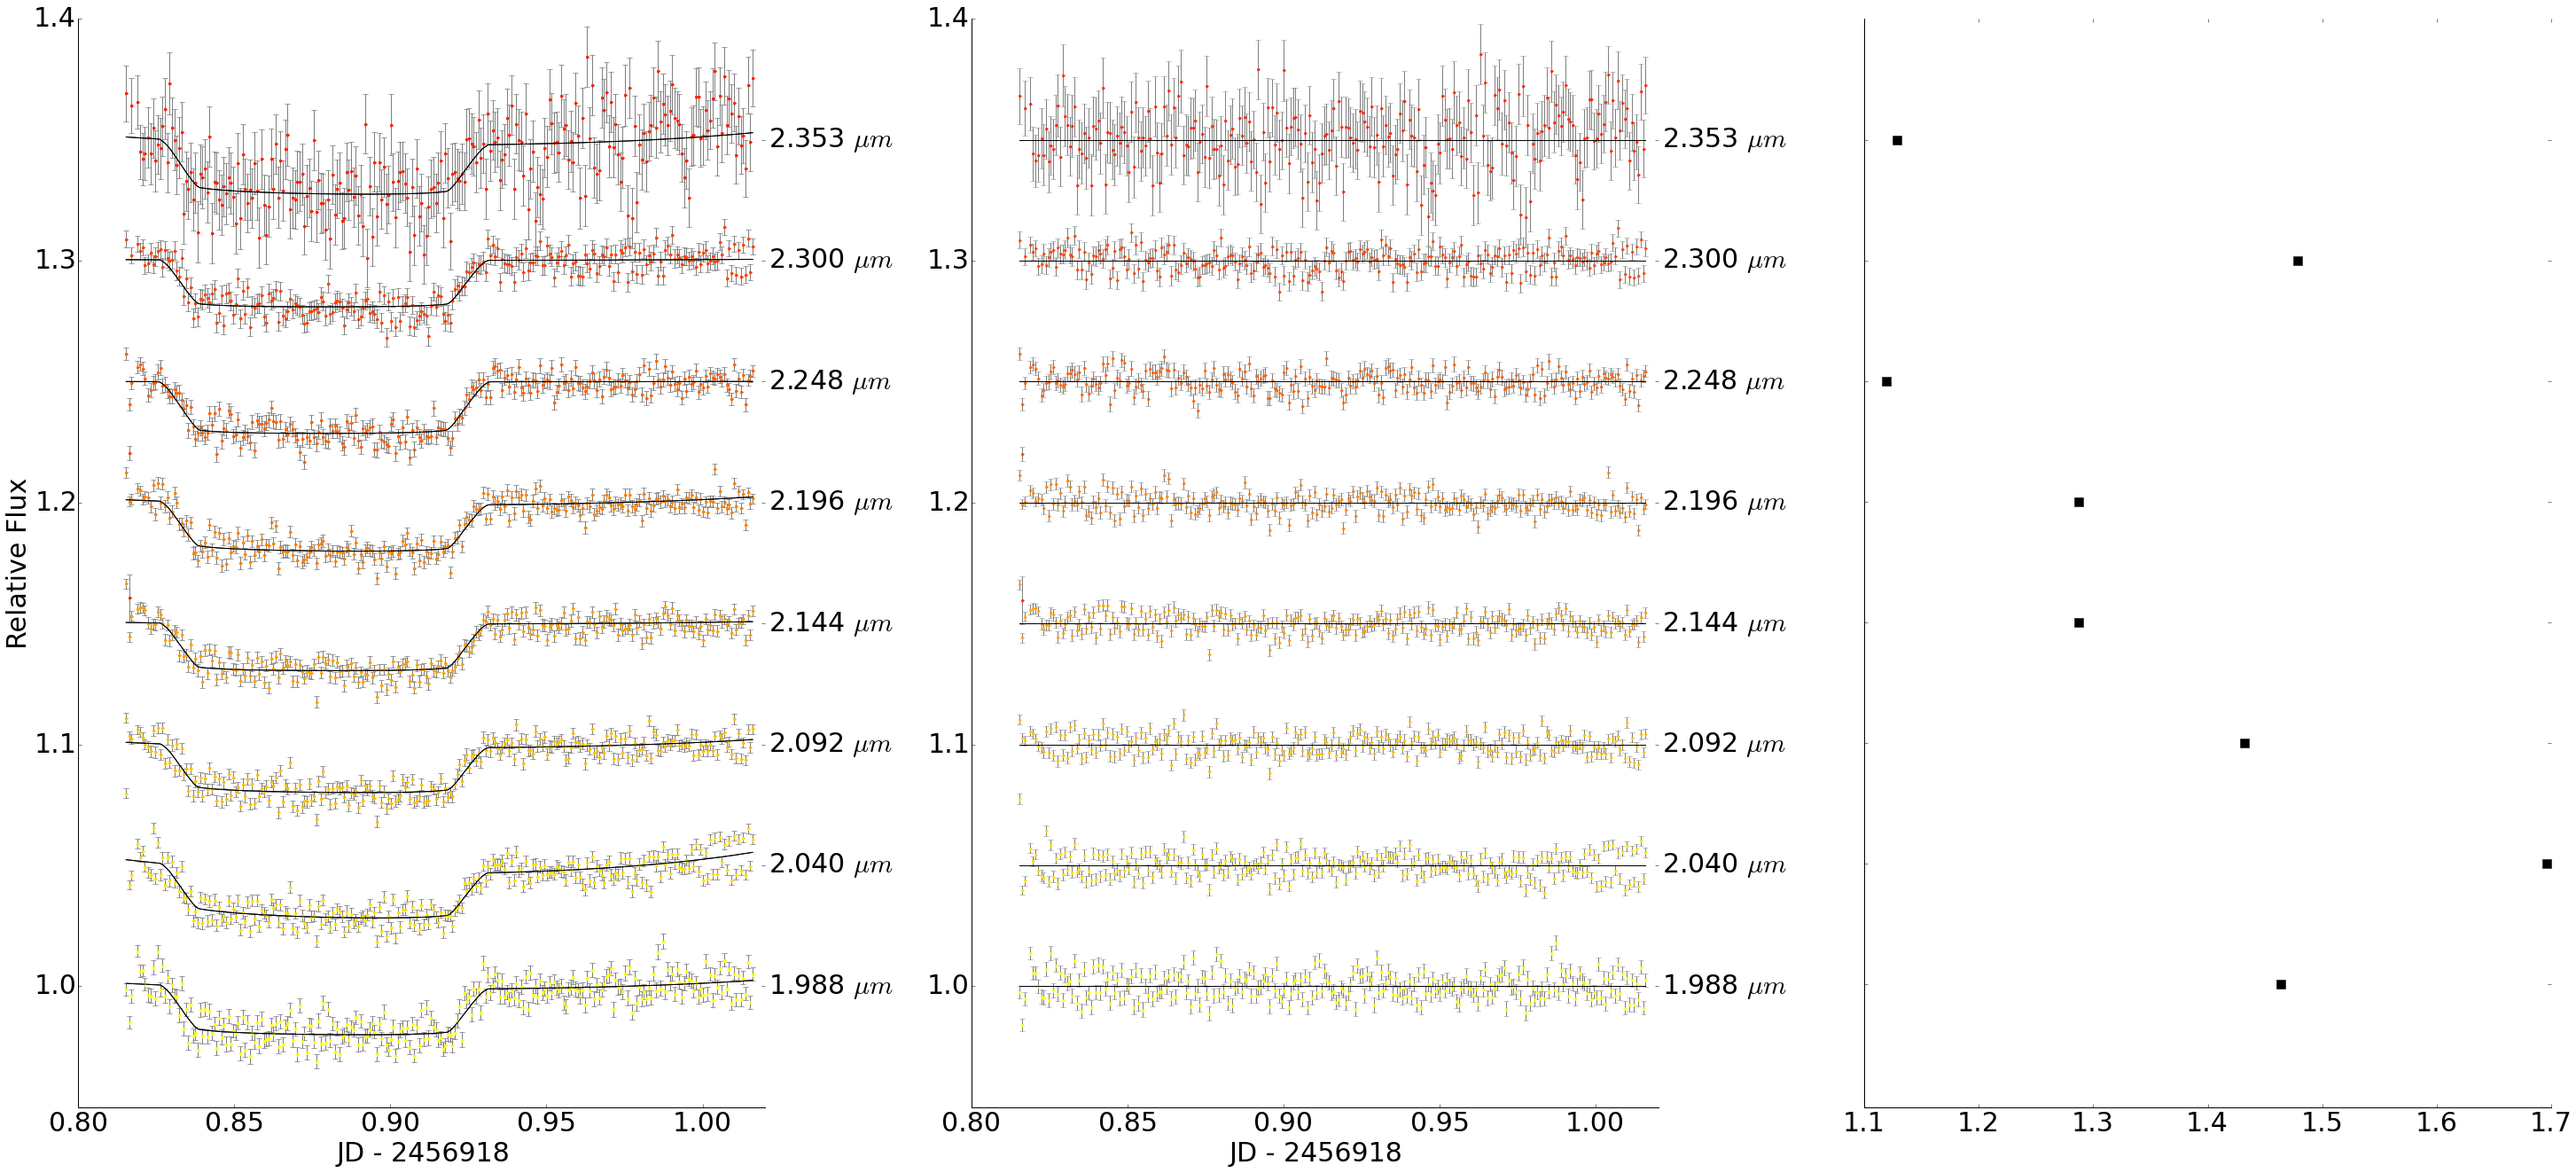

In [524]:
matplotlib.rcParams['font.size'] = 30
Nbins = np.shape(lightcurve)[1]
#model = genmodel(max_lnp_params)
mintimeint = int(np.min(times))
cmap = plt.cm.autumn
spread = 0.05
t0_roughfit = 2456918.8793039066
t14duration_expected = 0.1086 # days

fig, ax = plt.subplots(1, 3, figsize=(50,22))
#ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

ax1 = fig.add_subplot(131, frameon=False)#sharey=ax[1],
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax1.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax1.set_xticks([])

ax2 = fig.add_subplot(132, frameon=False)#sharey=ax[1],
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax2.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax2.set_xticks([])


for eachbin in range(len(lightcurve[0,:])):
    oot = (times < t0_roughfit - t14duration_expected/2.0) + \
          (times > t0_roughfit + t14duration_expected/2.0)
    bestF0 = np.mean(lightcurve[:,eachbin][oot])
    lc = lightcurve[:,eachbin]/bestF0 + eachbin*spread
    modellc = model[:,eachbin]/bestF0 + eachbin*spread
    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[1].errorbar(times - mintimeint, lc - modellc  + eachbin*spread + 1, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(times - mintimeint, np.zeros_like(modellc) + eachbin*spread + 1, \
                color='k')
    
ax[2].plot(Nphotonnoise, wavelengthbincenters, 'ks', markersize=10)
#ax[2].set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax[2].set_yticks(wavelengthbincenters)
#ax[2].set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax[2].set_yticklabels([])
ax[2].set_ylim([1.935, 2.405])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

ax[0].set_ylabel('Relative Flux')    
#ax[0].set_ylim([0.95, 1.50])
ax2.set_ylim([0.95, 1.40])
ax1.set_ylim([0.95, 1.40])
#ax[1].set_ylabel('Residuals')    
#ax.grid()
for i in [0,1]:
    ax[i].set_xlabel('JD - %d' % mintimeint)
    ax[i].set_xlim([0.8, 1.02])
    ax[i].set_ylim([0.95, 1.40])
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[0].set_title('Max $\log p$ Light Curves')
fig.subplots_adjust(wspace=0.3)
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/max_lnp_lightcurves_photonnoise_poster.eps', bbox_inches='tight')
plt.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


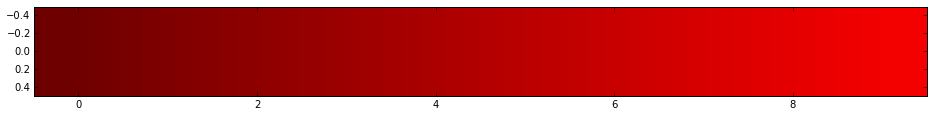

In [525]:
%pylab inline
#Experimental colormap

# Custom black-to-red colormap
lowred = 0.4
highred = 0.95
Nrows = 100
reds = np.linspace(lowred, highred, Nrows)**0.9
greens = np.zeros_like(reds)
blues = np.zeros_like(reds)

colormatrix = np.vstack([reds, greens, blues]).T
#print colormatrix
customcm = matplotlib.colors.ListedColormap(colormatrix)
fig = plt.figure(figsize=(16,2))
plt.imshow(np.arange(10).reshape(1,10), cmap=customcm) # for example
plt.show()

## Light curves and residuals and Photon noise  and using grispec

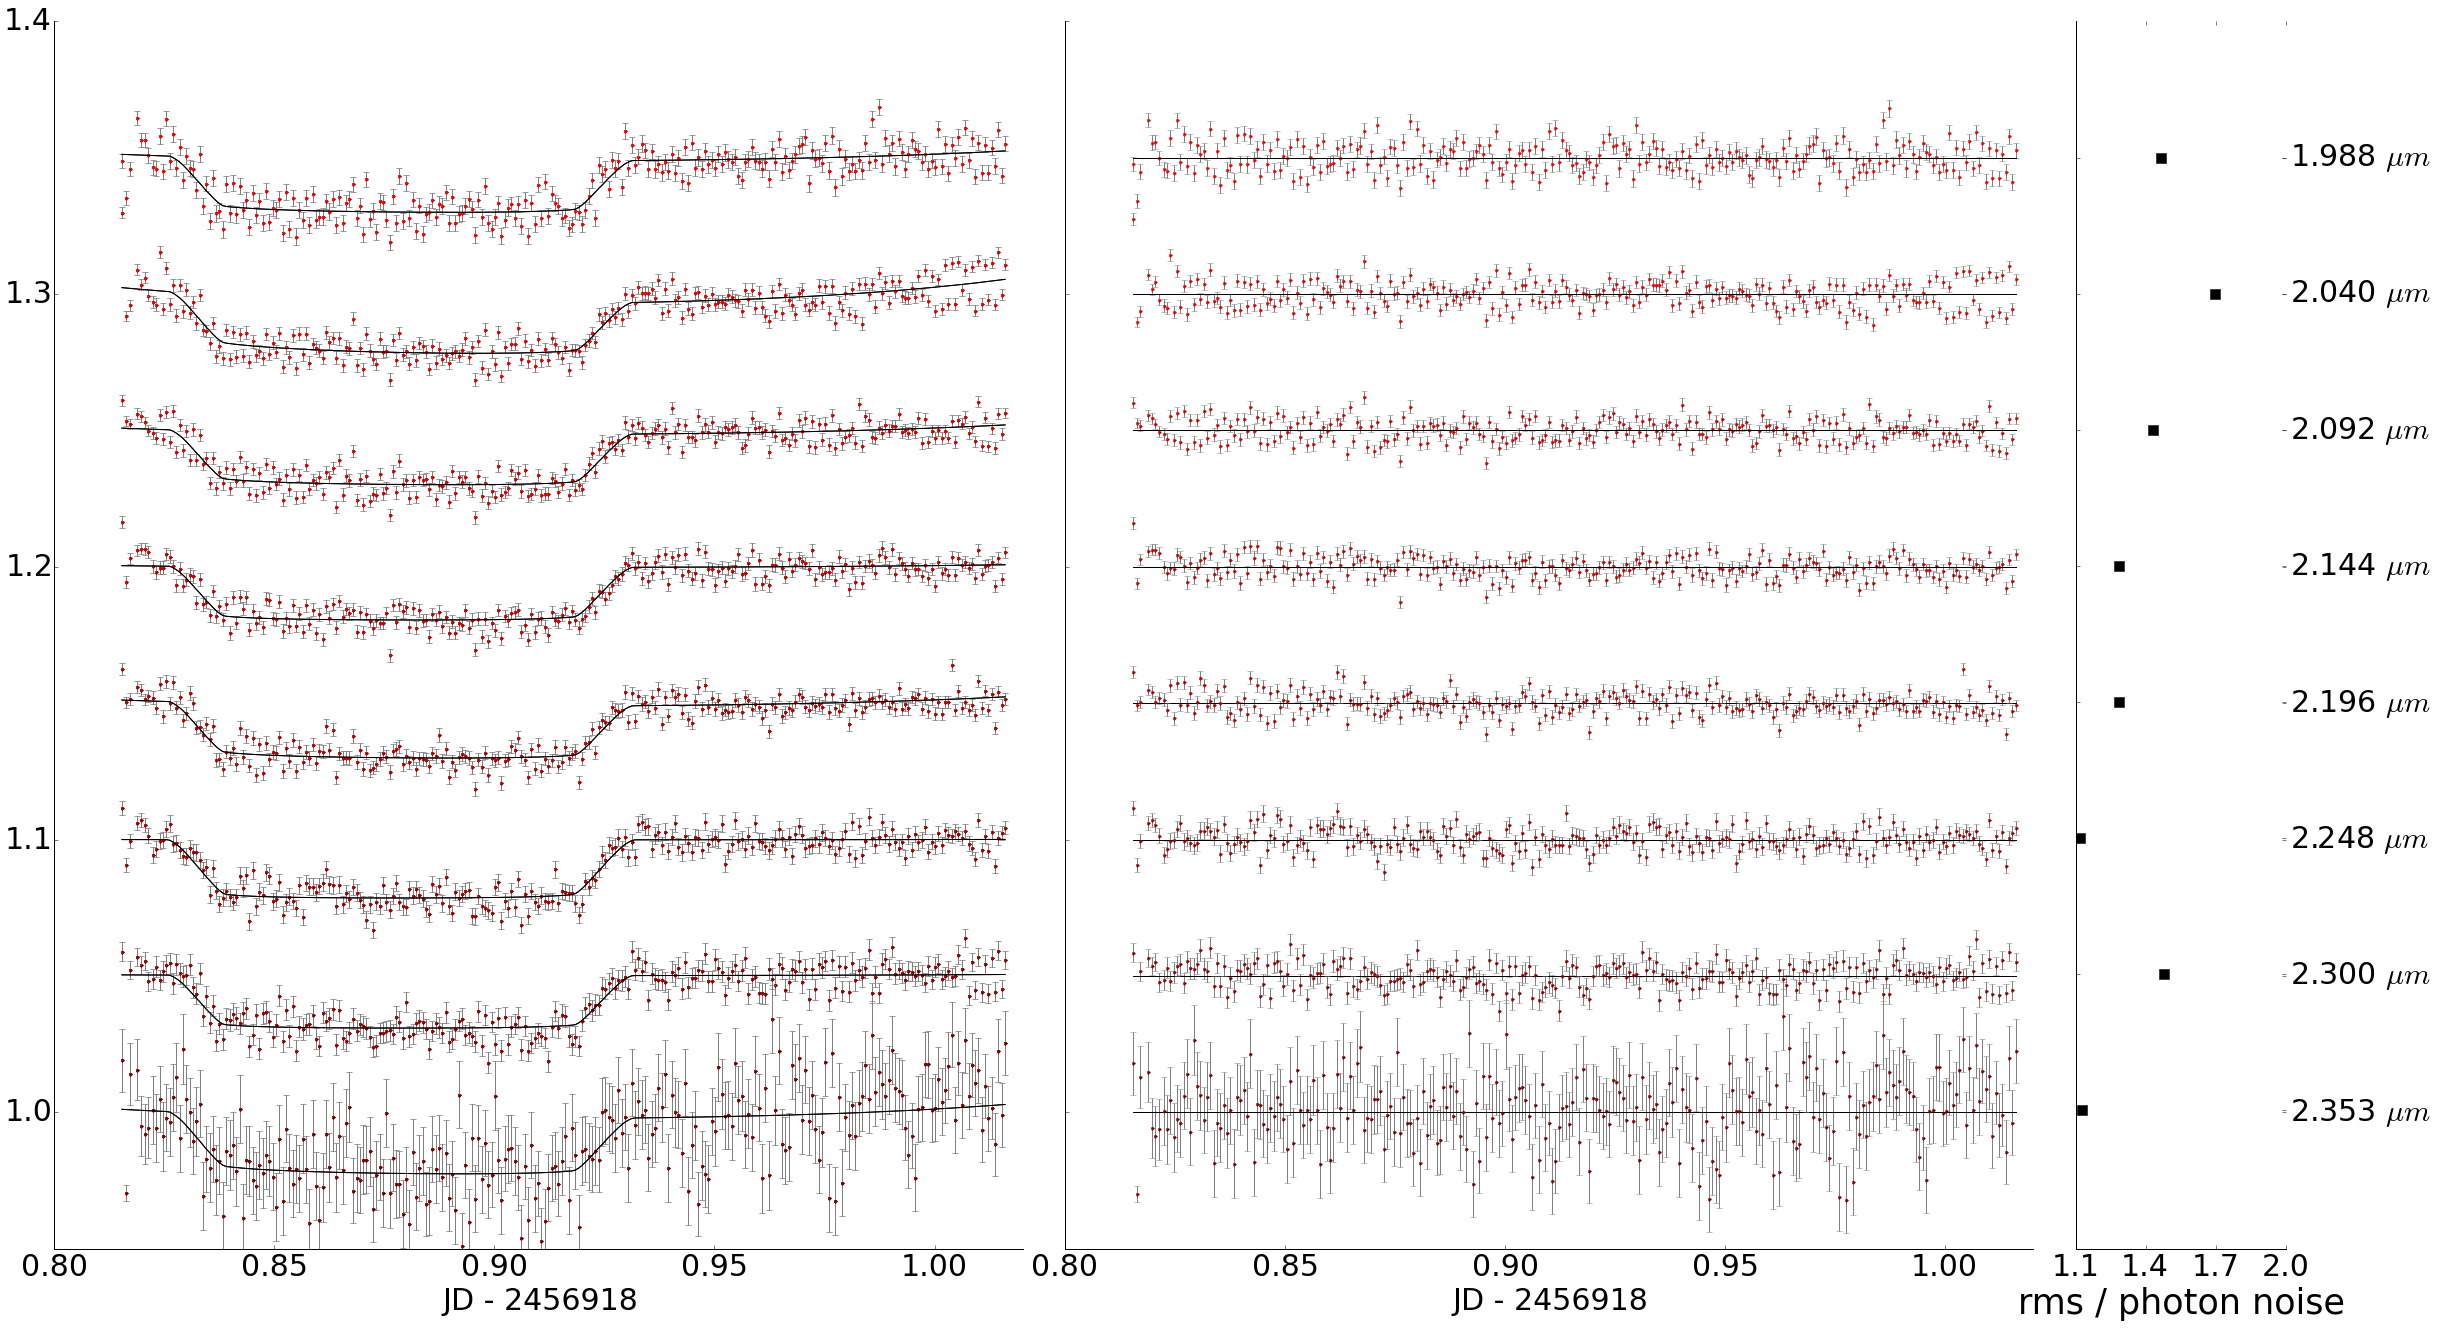

In [529]:
matplotlib.rcParams['font.size'] = 30
Nbins = np.shape(lightcurve)[1]
#model = genmodel(max_lnp_params)
mintimeint = int(np.min(times))
cmap = customcm
spread = 0.05
t0_roughfit = 2456918.8793039066
t14duration_expected = 0.1086 # days

#fig, ax = plt.subplots(1, 3, figsize=(50,22))
fig = plt.figure(figsize=(40,22))
gs = gridspec.GridSpec(1, 9)
ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[0, 4:8])
ax3 = plt.subplot(gs[0, 8])
ax = [ax1, ax2, ax3] 
#ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

# ax1 = fig.add_subplot(194, frameon=False)#sharey=ax[1],
# ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position("right")
# ax1.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
# ax1.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters[::-1]))
# ax1.set_xticks([])

ax2 = fig.add_subplot(199, frameon=False)#sharey=ax[1],
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax2.set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters[::-1]))
ax2.set_xticks([])


for eachbin, offset in zip(range(len(lightcurve[0,:])), range(len(lightcurve[0,:]))[::-1]):
    oot = (times < t0_roughfit - t14duration_expected/2.0) + \
          (times > t0_roughfit + t14duration_expected/2.0)
    bestF0 = np.mean(lightcurve[:,eachbin][oot])
    lc = lightcurve[:,eachbin]/bestF0 + offset*spread
    modellc = model[:,eachbin]/bestF0 + offset*spread
    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[0].errorbar(times - mintimeint, lc, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0].plot(times - mintimeint, modellc, 'k')

    ax[1].errorbar(times - mintimeint, lc - modellc  + offset*spread + 1, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[1].plot(times - mintimeint, np.zeros_like(modellc) + eachbin*spread + 1, \
                color='k')
    
ax[2].plot(Nphotonnoise, wavelengthbincenters[::-1], 'ks', markersize=10)
#ax[2].set_yticks([1 + eachbin*spread for eachbin in range(Nbins)])
ax[2].set_yticks(wavelengthbincenters)
#ax[2].set_yticklabels(map(lambda x: '%.3f $\mu m$' % x, wavelengthbincenters))
ax[2].set_yticklabels([])
ax[2].set_ylim([1.935, 2.405])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_xticks(np.arange(1.1, 2.2, 0.3))
ax[2].set_xlabel('rms / photon noise', fontsize=35)

#ax[0].set_ylabel('Relative Flux')    
ax[1].set_yticklabels([])

ax2.set_ylim([0.95, 1.40])
ax1.set_ylim([0.95, 1.40])
#ax[1].set_ylabel('Residuals')    
#ax.grid()
for i in [0,1]:
    ax[i].set_xlabel('JD - %d' % mintimeint)
    ax[i].set_xlim([0.8, 1.02])
    ax[i].set_ylim([0.95, 1.40])
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[0].set_title('Max $\log p$ Light Curves')
fig.subplots_adjust(wspace=0.2)

#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/max_lnp_lightcurves_photonnoise_poster.eps', bbox_inches='tight')
plt.show()

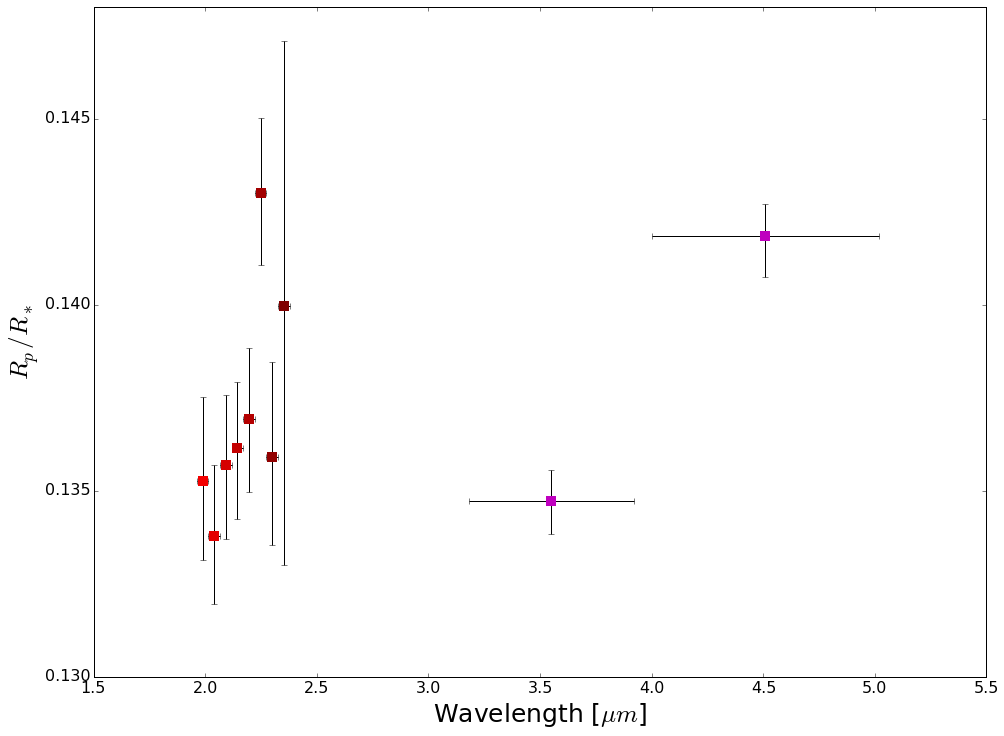

In [630]:
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(16,12))
histbins = 15

def depthhist(ax, eachbin):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    RpRs = samples[:,10+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax.errorbar(wavelengthbincenters[eachbin], bestRpRs, yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters))), \
                  ecolor='k', markeredgecolor='none', ms=10)
    return bestRpRs, bestRpRsplus, bestRpRsminus
    
def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = wave_nik[-2:]#[3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax.errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color='m',
                  ecolor='k', markeredgecolor='none', ms=10)
    #color=cmap(1 - i/float(len(wavelengthbincenters_spitz))),
    
spectrum = []
for i in range(Nbins):
    spectrum.append(depthhist(ax, i))
    
for i in range(2):
    spectrum.append(depthhistspitz(ax, i))
    
np.save('spectrum.npy',spectrum)
    
labelsize = 25
ax.set_xlabel('Wavelength [$\mu m$]', fontsize=labelsize)
ax.set_ylabel(r'$R_p/R_*$', fontsize=labelsize)
#fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/simplespectrum.eps', bbox_inches='tight')
plt.show()

87808 64


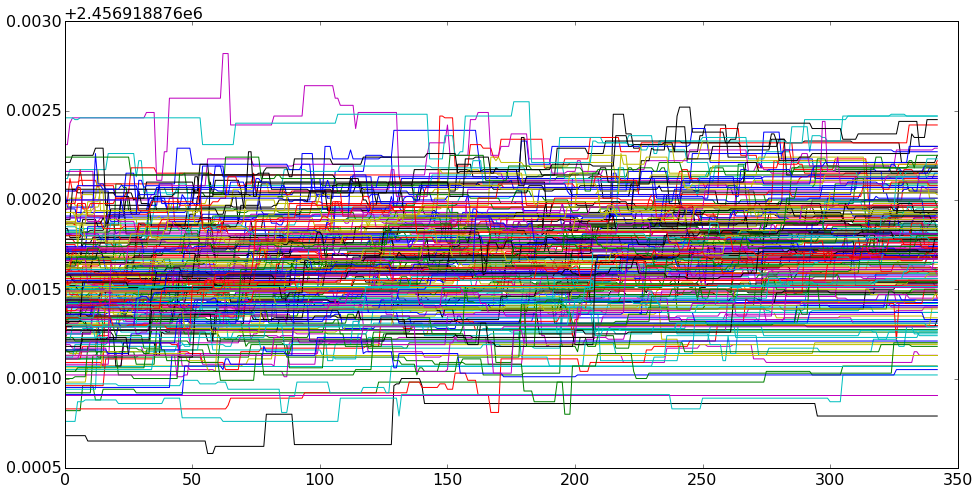

In [158]:
fig, ax = plt.subplots(figsize=(16,8))
n, m = samples.shape
print n, m
for j in [2]:
    [ax.plot(samples[i:,j][::4*m]) for i in range(4*m)]
    plt.show()

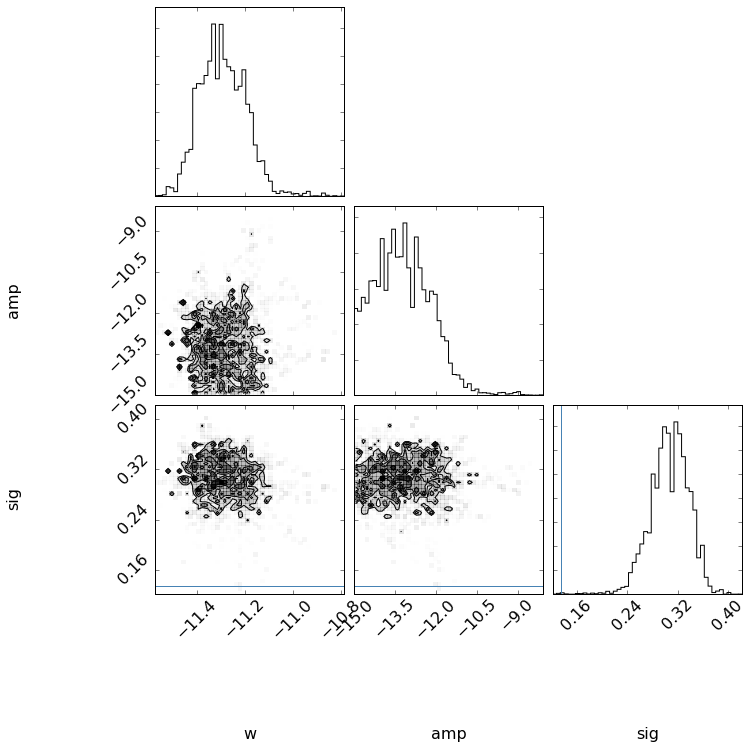

In [152]:
trifig, ax = plt.subplots(3, 3, figsize=(10, 10))
binnum = 0
fig2 = triangle.corner(samples[:, [-Nlightcurves-2*Nbins+binnum, -2*Nbins+binnum, 
                                   -Nbins+binnum]], 
                       labels=['w','amp','sig'], 
                       fig=trifig, plot_datapoints=False, 
                       truths=np.median(samples[:, [0+binnum, 8+binnum, 16+binnum]],axis=0))
#, truths=max_lnp_params[0:4]) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()